In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
import sys 
sys.path.append('./models/')
from Model import Model 

In [2]:
df = pd.read_csv('deaths_and_infections.csv')

# remove a columns from a df: 
df.drop(columns=['Unnamed: 0'], inplace=True)
new_deaths=np.array(df['new_deaths'])
death_cumul=np.array([sum(new_deaths[:i]) for i in range(len(new_deaths))])
dates_of_pandemic=np.arange(len(new_deaths))

In [3]:
def exponential_func(x, a, b, c):
    return a*np.exp(b*x)+c

[  1.27331544   0.18555633 -34.72327539]


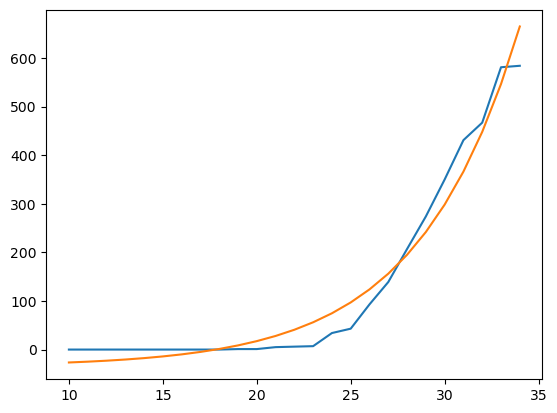

In [9]:
min=len(new_deaths)
max=35
interval=[i for i in range(min,max)]
p, cov =curve_fit(exponential_func, dates_of_pandemic[interval], new_deaths[interval], p0=[ 1.33991316e+01 , 1.21453531e-01,  -1.92062731e+02], maxfev = 10000)
print(p)
plt.plot(dates_of_pandemic[interval], new_deaths[interval])
plt.plot(dates_of_pandemic[interval], exponential_func(dates_of_pandemic[interval], *p))

In [89]:
# IC with the formula in paper 3: 

def h(theta, x_i):
    return theta[0]*np.exp(theta[1]*x_i)+theta[2]

def grad_theta(theta, x_i): 
    d_theta=0.01
    grad=np.zeros(len(theta))
    for i in range(len(theta)): 
        theta_plus=theta.copy()
        theta_plus[i]+=d_theta
        grad[i]=(h(theta_plus,x_i)-h(theta,x_i))/d_theta
    return grad


def compute_A(theta, X): 
    A=np.zeros((len(X), len(theta)))
    for i in range(len(X)): 
        A[i]=grad_theta(theta, X[i])
    return A


def estimate_sigma2(data, prediction,d): 
    return np.sum((data-prediction)**2)/(len(data)-d)

In [104]:
A=np.array([[1,2,3],[4,8,6], [7,8,9]])
np.matmul( A, np.linalg.inv(A))

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [112]:
class ExponentialRegression(Model): 
    def train(self, train_dates, data):
        self.data=data
        self.train_dates=train_dates
        min=len(data)-15
        max=len(data)-1
        interval=[i for i in range(min,max)]
        self.interval=interval
        self.p, self.cov =curve_fit(exponential_func, train_dates[interval], data[interval], p0=[ 1.33991316e+01 , 1.21453531e-01,  -1.92062731e+02], maxfev = 10000)
        self.trained=True


    def predict(self, reach, alpha, method='njsdijbvi'):
        assert self.trained, 'The model has not been trained yet'
        a=self.p[0]
        b=self.p[1]
        c=self.p[2]
        window_prediction=np.array([i for i in range(len(self.train_dates), len(self.train_dates) + 7)])
      
        prediction=exponential_func(window_prediction,a,b,c)

        if method == 'covariance': 
            perr = np.sqrt(np.diag(self.cov))
        else: 
            sigma2=estimate_sigma2(self.data[self.interval], exponential_func(self.train_dates[self.interval], *self.p), 3)
            A=compute_A(self.p, self.train_dates[self.interval])
            cov=sigma2*np.linalg.inv(np.matmul(A.transpose(), A))/len(self.interval)
            perr=np.sqrt(np.diag(cov))

        intervals=[prediction]
        a_sampled=[]
        b_sampled=[]
        c_sampled=[]
        for i in range(100): 
            a_r= np.random.normal(self.p[0], perr[0], 1)[0]
            b_r=np.random.normal(self.p[1], perr[1], 1)[0]
            c_r=np.random.normal(self.p[2], perr[2], 1)[0]
            a_sampled.append(a_r)
        
            b_sampled.append(b_r)
            c_sampled.append(c_r)
            prediction_sampled=exponential_func(window_prediction,a_r, b_r,c_r)
            intervals.append(prediction_sampled)
        self.a_sampled=a_sampled
        self.b_sampled=b_sampled
        self.c_sampled=c_sampled
        intervals=np.array(intervals).transpose()
        self.intervals=intervals
        ci_low=np.array([np.quantile(intervals[i], alpha/2) for i in range(reach)])
        ci_high=np.array([np.quantile(intervals[i],1-alpha/2) for i in range(reach)])
        return prediction, [ci_low, ci_high]




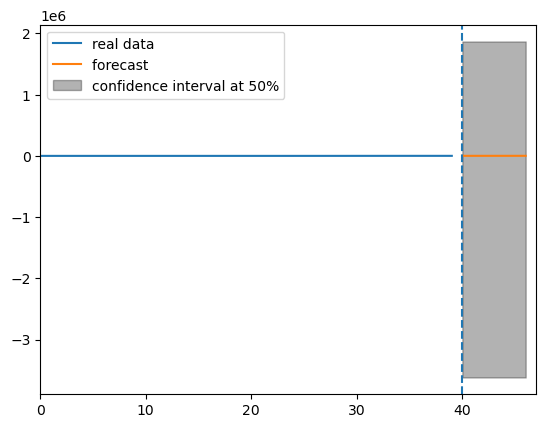

In [113]:
mymodel=ExponentialRegression()
mymodel.train(dates_of_pandemic[:40], new_deaths[:40])

prediction, intervals=mymodel.predict(7, 0.05, method='nuib')
mymodel.plot(7, 0.5)
